In [3]:
# Importando as bibliotecas necessárias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import yfinance as yf  # Para baixar dados de ações diretamente do Yahoo Finance
import requests
from bs4 import BeautifulSoup  # Para scraping de notícias financeiras

In [4]:
# Coletando dados de ações da Apple
data = yf.download('AAPL', start='2010-01-01', end='2023-01-01')
data['Date'] = data.index

[*********************100%***********************]  1 of 1 completed


In [5]:
# Função de scraping para coletar dados de sentimento de mercado (notícias, etc.)
def get_market_sentiment():
    url = 'https://finance.yahoo.com/quote/AAPL/news'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    articles = soup.find_all('h3', class_='Mb(5px)')
    sentiment = []
    for article in articles:
        sentiment.append(article.get_text())
    return sentiment

In [6]:
# Convertendo a coluna Date para datetime
data['Date'] = pd.to_datetime(data['Date'])

# Criando novas features - médias móveis e volatilidade
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_20'] = data['Close'].rolling(window=20).mean()
data['Volatility'] = data['Close'].rolling(window=20).std()

# Tratando dados ausentes (se houver)
data.dropna(inplace=True)

In [7]:
# Engenharia de Features: Utilizando dados históricos e novos dados criados
X = data[['Close', 'Volume', 'MA_5', 'MA_20', 'Volatility']]
y = data['Close']

# Dividindo os dados em treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelagem com XGBoost
xgb_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)

# Fazendo previsões com XGBoost
y_pred_xgb = xgb_model.predict(X_test)

# Avaliando o modelo XGBoost
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost - MAE: {mae_xgb}, MSE: {mse_xgb}, R²: {r2_xgb}")

XGBoost - MAE: 0.19898647903114236, MSE: 0.2638436280333106, R²: 0.9998795127032483


In [8]:
# Modelagem com Redes Neurais LSTM
# Preparando os dados para o modelo LSTM
X_train_lstm = np.reshape(X_train.values, (X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = np.reshape(X_test.values, (X_test.shape[0], X_test.shape[1], 1))

# Criando o modelo LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(LSTM(50, return_sequences=False))
lstm_model.add(Dense(25))
lstm_model.add(Dense(1))

# Compilando o modelo LSTM
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

# Treinando o modelo LSTM
lstm_model.fit(X_train_lstm, y_train, batch_size=1, epochs=10)

# Fazendo previsões com o modelo LSTM
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Avaliando o modelo LSTM
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)

print(f"LSTM - MAE: {mae_lstm}, MSE: {mse_lstm}, R²: {r2_lstm}")



Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2602/2602 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 813.8792
Epoch 2/10
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 21.4236
Epoch 3/10
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 24.1782
Epoch 4/10
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 16.9348
Epoch 5/10
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 19.1891
Epoch 6/10
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - loss: 14.8783
Epoch 7/10
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 13.5568
Epoch 8/10
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 9.8093
Epoch 9/10
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 10.6138
Epoch 10/10
2602/2602 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 10.1369
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
LSTM - MAE: 2.2892691550716275, MSE: 21.831601984903553, R²: 0.990030342113894


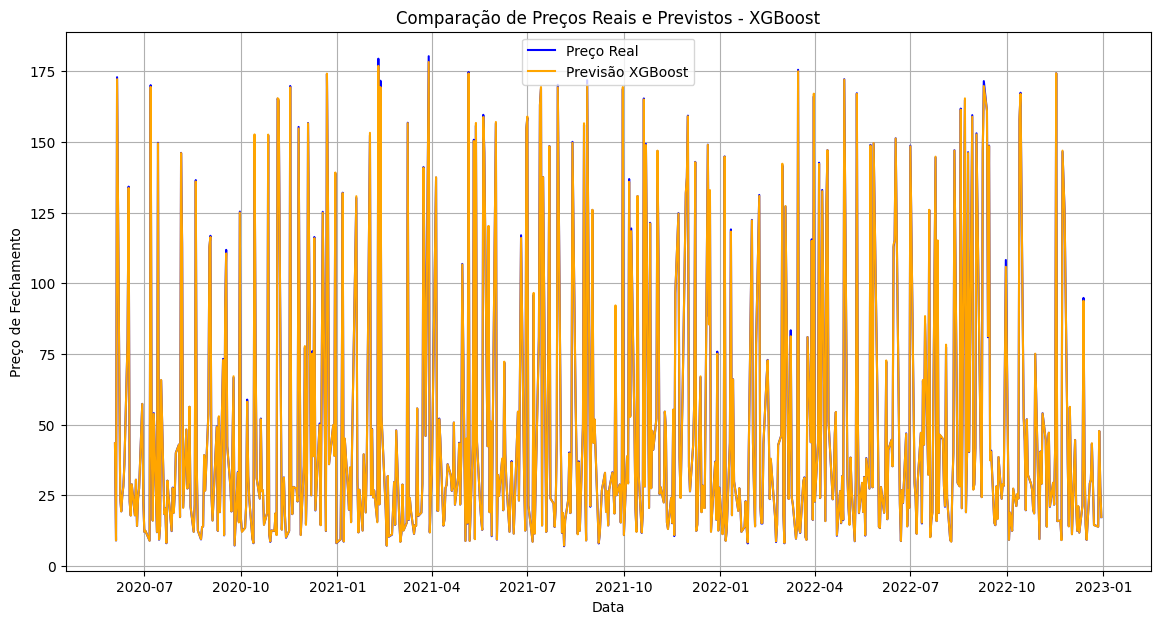

In [9]:
# Visualizando as previsões do XGBoost e do LSTM

# Comparando previsões do XGBoost
plt.figure(figsize=(14, 7))
plt.plot(data['Date'][-len(y_test):], y_test, label='Preço Real', color='blue')
plt.plot(data['Date'][-len(y_test):], y_pred_xgb, label='Previsão XGBoost', color='orange')
plt.title('Comparação de Preços Reais e Previstos - XGBoost')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

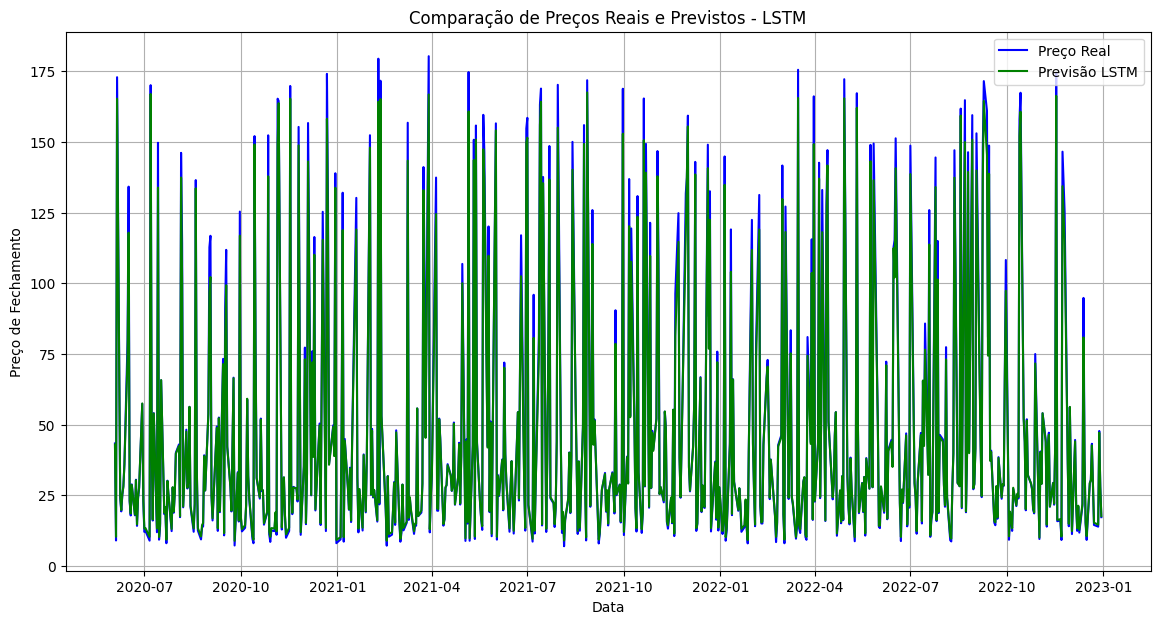

In [10]:
# Comparando previsões do LSTM
plt.figure(figsize=(14, 7))
plt.plot(data['Date'][-len(y_test):], y_test, label='Preço Real', color='blue')
plt.plot(data['Date'][-len(y_test):], y_pred_lstm, label='Previsão LSTM', color='green')
plt.title('Comparação de Preços Reais e Previstos - LSTM')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento')
plt.legend()
plt.grid(True)
plt.show()

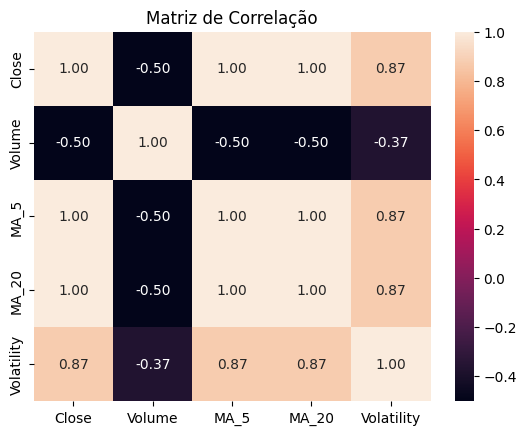

In [11]:
# Visualizando a matriz de correlação
numerical_data = data[['Close', 'Volume', 'MA_5', 'MA_20', 'Volatility']]
sns.heatmap(numerical_data.corr(), annot=True, fmt=".2f")
plt.title('Matriz de Correlação')
plt.show()


[*********************100%***********************]  1 of 1 completed


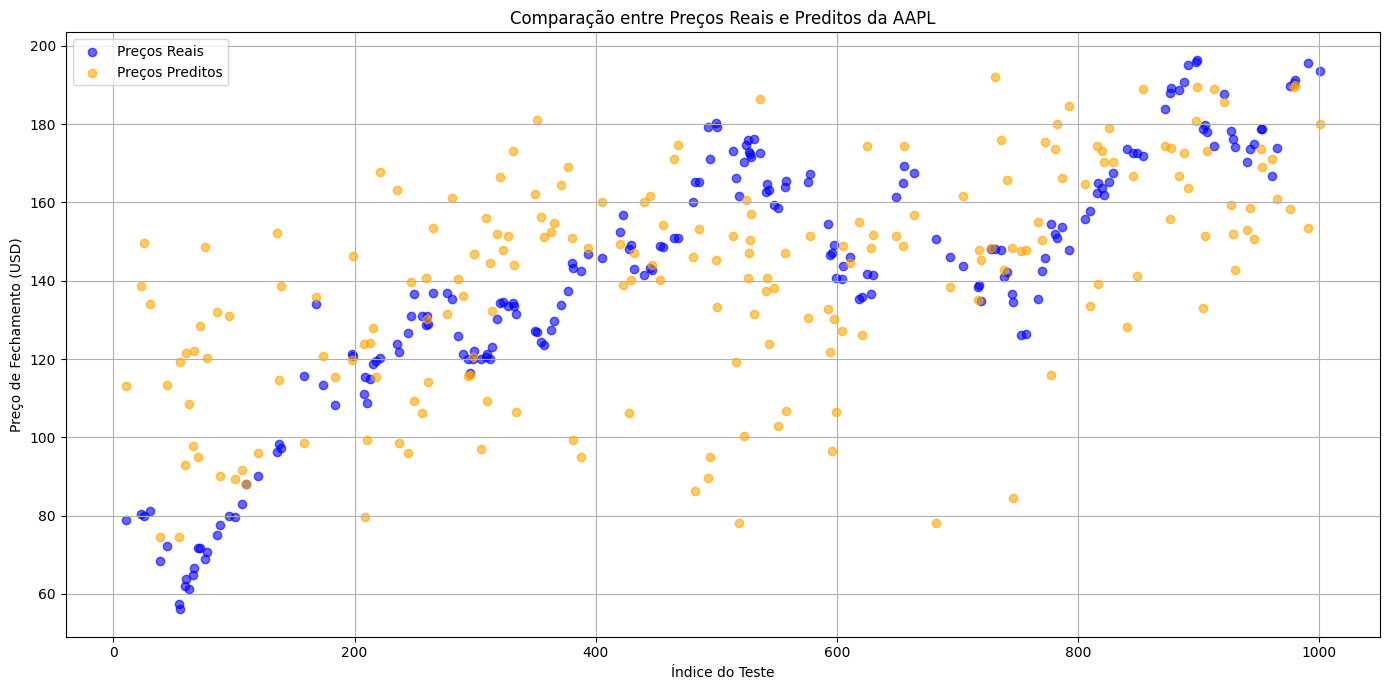

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import yfinance as yf

# Coletando dados da Apple
data = yf.download('AAPL', start='2020-01-01', end='2024-01-01')

# Preparando os dados
data['Date'] = data.index
data.reset_index(drop=True, inplace=True)

# Aqui, dividimos os dados para criar um modelo de exemplo
X = data[['Volume']]  # Exemplo de feature
y = data['Close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinando um modelo de Random Forest
modelo_rf = RandomForestRegressor()
modelo_rf.fit(X_train, y_train)

# Fazendo previsões
y_pred = modelo_rf.predict(X_test)

# Visualização: Comparação entre Preços Reais e Previsões
plt.figure(figsize=(14, 7))
plt.scatter(y_test.index, y_test, label='Preços Reais', color='blue', alpha=0.6)
plt.scatter(y_test.index, y_pred, label='Preços Preditos', color='orange', alpha=0.6)
plt.title('Comparação entre Preços Reais e Preditos da AAPL')
plt.xlabel('Índice do Teste')
plt.ylabel('Preço de Fechamento (USD)')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
